In [26]:
import math
import numpy as np
import matplotlib.pyplot as plt
from qiskit import *
from qiskit.algorithms import Shor

from warnings import filterwarnings
filterwarnings("ignore")

In [27]:
N = 15
a = 13

#N = 21
#a = 2

# Classic Algorithm

In [28]:
math.gcd(a, N)

1

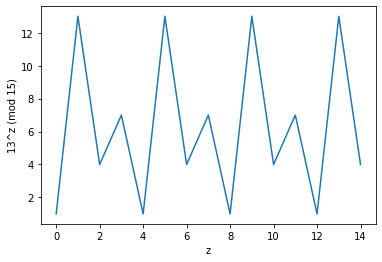

In [29]:
z = list(range(N))
y = [a**z0 % N for z0 in z]

plt.plot(z,y)
plt.xlabel('z')
plt.ylabel(f'{a}^z (mod {N})')
plt.show()

In [30]:
r = z[y[1:].index(1)+1]
print(r)

4


In [31]:
if r % 2 == 0:
    x = (a**(r/2.)) % N
    print(f'x: {x}')
    if((x+1) % N) != 0:
        print(math.gcd((int(x)+1),N), math.gcd((int(x)-1),N))
    else:
        print('x+1 is 0 (mod N)')
else:
    print('r is odd')

x: 4.0
5 3


# Simple Shor's Algorithm

In [32]:
quantum_instance = Aer.get_backend("qasm_simulator")
shor = Shor(quantum_instance=quantum_instance)

result = shor.factor(N=15, a=7)
print("Factors",result.factors)

Factors [[3, 5]]


# Quantum Phase Estimation

In [33]:
for y in range(15):
    result = np.exp(-1j*3*np.pi/8*y) + np.exp(-1j*7*np.pi/8*y) + np.exp(-1j*11*np.pi/8*y) + np.exp(-1j*15*np.pi/8*y)
    if abs(result) < 1e-10: 
        result = 0
    print(y, result)

0 (4+0j)
1 0
2 0
3 0
4 (-5.757077917265737e-15+4j)
5 0
6 0
7 0
8 (-4-1.1514155834531474e-14j)
9 0
10 0
11 0
12 (2.2600304269997962e-14-4j)
13 0
14 0


## Manual

In [34]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,7,8,11,13]:
        raise ValueError("'a' must be 2,7,8,11 or 13")
    U = QuantumCircuit(4)        
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 11:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U

In [35]:
n_count = 8
a = 7

In [36]:
def qft_dagger(n):
    qc = QuantumCircuit(n)
    for qubit in range(n//2):
        qc.swap(qubit,n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cu1(-np.pi/float(2**(j-m)),m,j)
        qc.h(j)
    qc.name = "QFT Dagger"
    return qc

### Create QuantumCircuit with n_count counting qubits plus 4 qubits for U to act on

In [37]:
qc = QuantumCircuit(n_count + 4, n_count)

### Initialize counting qubits in state |+>

In [38]:
for q in range(n_count):
    qc.h(q)

### And auxiliary register in state |1>

In [39]:
qc.x(3+n_count)

### Do controlled-U operations

In [40]:
for q in range(n_count):
    qc.append(c_amod15(a, 2**q), 
             [q] + [i+n_count for i in range(4)])

### Do inverse-QFT

In [41]:
qc.append(qft_dagger(n_count), range(n_count))

### Measure circuit

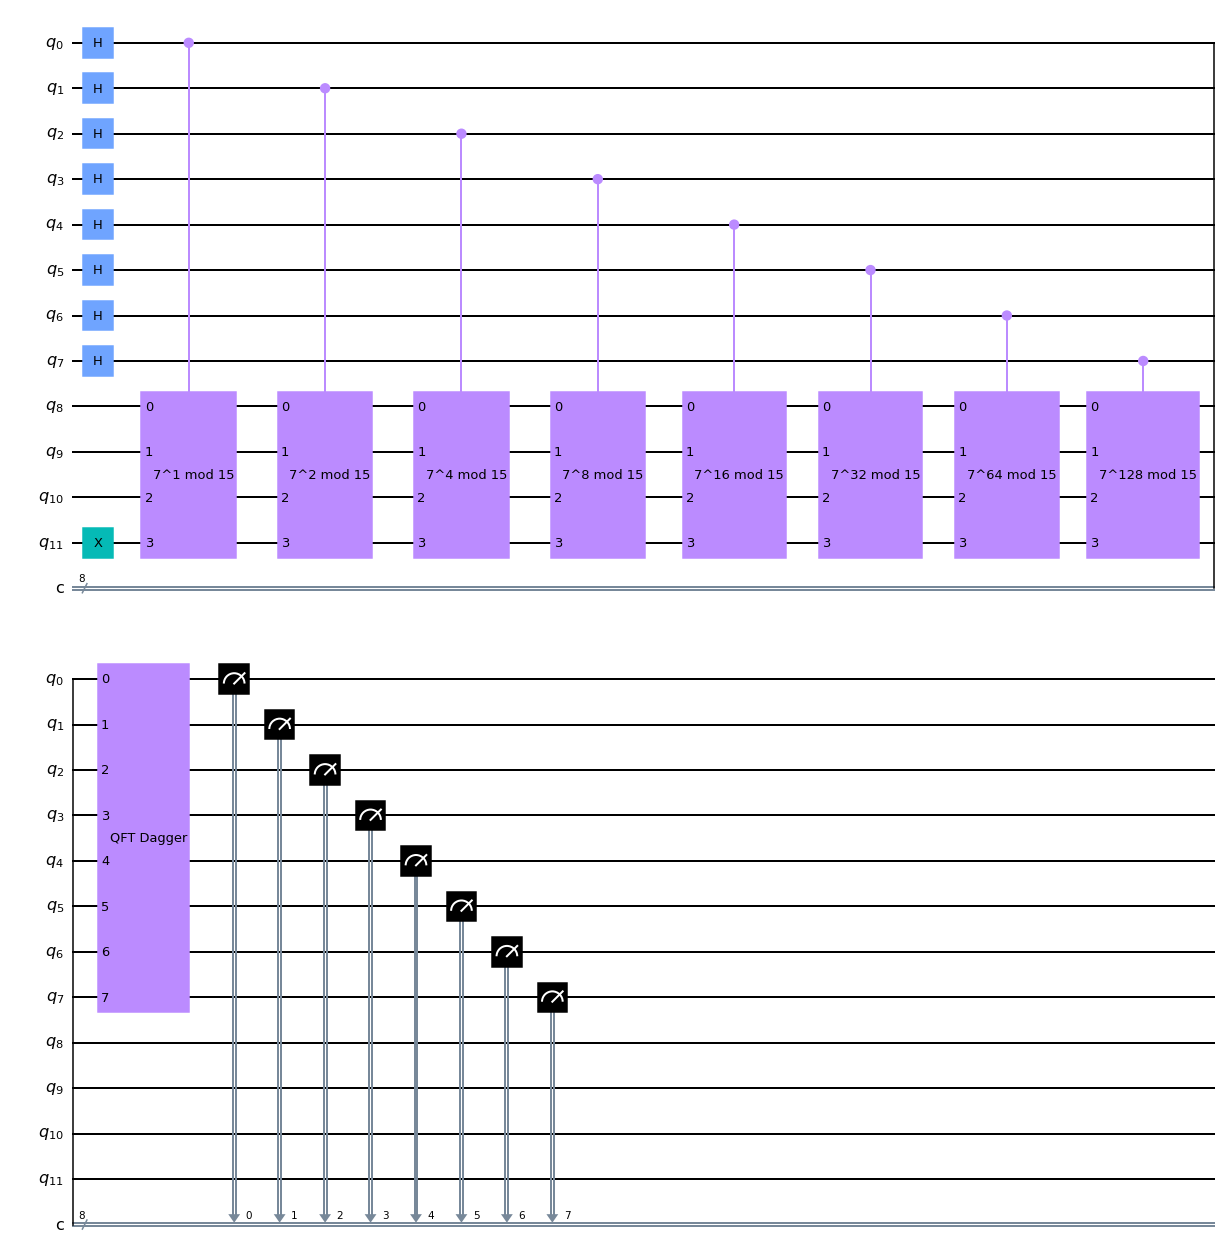

In [42]:
qc.measure(range(n_count), range(n_count))

qc.draw(output='mpl')